<a href="https://colab.research.google.com/github/jodejetalo99/Introduccion-al-Aprendizaje-Profundo/blob/main/Proyecto/Proyecto_AP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto: Conteo y clasificación por audio
### Universidad Nacional Autónoma de México
### Licenciatura en Ciencia de Datos
## - Martiñón Luna Jonathan José
## - Tapia López José de Jesús

# Importando Librerías

In [1]:
from os.path import join
import librosa
import librosa.display
import IPython as ip
try:
    import torchaudio
except:
    !pip install torchaudio
    import torchaudio
import torch
import json
from random import randint, seed, choice
from time import time
import pylab 

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

#Almacenamiento de audio
import scipy.io.wavfile as waves


     |████████████████████████████████| 1.9MB 4.0MB/s 


# Funciones

In [2]:
def corta_audio(registro):
    '''
    
    @Autor: José de Jesús Tapia López
    
    @Descripción:  Función encargada de recortar el audio.
                   Teniendo en cuenta que podemos tener de
                   distintas duraciones. Nos aseguraremos
                   de tomar una sección aleatoria con dura-
                   ción de 1 segundo
    
    @Parámetros:
    
    registro       Registro del conjunto de datos que contiene    TUPLE
                   el audio a cortar. 
    
    @Devuelve:     Audio del registro, recortado. 
    '''
    
    # Obtenemos la longitud total del audio
    lon = len(registro[0][0])

    # Generamos un aleatorio de 0 a la longitud - 16,000
    # Para capturar sólo una sección aleatorio, pero asegurándonos de 
    # Que podrá ser de 16,000
    start = randint(0,lon-16000)

    # Una vez que tenemos el inicio, bastará con sumarle 1600
    # Para determinar el final
    finish = start + 16000

    # Devolvemos nuestra onda como arreglo de numpy
    return registro[0][0][start:finish].squeeze().numpy()
    

In [3]:
def Encuentra_Registro(data,id,speakers_df):
    '''
    
    @Autor: Jonathan José Martiñón Luna
    
    @Descripción:   Dado que nuestros registros se encontraban con 
                    estructura de tuplas, no encontramos otra forma
                    sino buscar en cada elemento, hasta extraer aquella
                    con el id de speaker seleccionado :c.
                    Si convertíamos a DataFrame, se llevaba la RAM.

    @Parámetros:
    
    data            Conjunto de datos donde obtendremos el registro    LIST
    id              Id de speaker a buscar su registro                 INT
    speakers_df     DataFrame con 1 columna llamada "Speakers_id"      DataFrame
                    con el objetivo de encontrar las posiciones
                    que corresponden al id buscado
                    
    @Devuelve:      Registro en forma de tupla de los elementos
    '''

    # Aislamos a las coincidencias en nuestro ID
    # Luego, obtenemos los índices para conocer su posición en la lista
    # Finalmente, para tener variedad, seleccionamos un audio aleatorio
    idx = choice(list(speakers_df[speakers_df["Speakers_id"]==id].index))

    # Devolvemos el audio seleccionado
    return data[idx]

In [4]:
def recolecta_registro(sex,data_Masc,data_Fem, audios, Speakers_df):
    '''
    
    @Autor: José de Jesús Tapia López
    
    @Descripción:   Función encargada de buscar un hablante aleatorio.
                    sea hombre o mujer. Y de dicho hablante, obtener 
                    sus datos

    @Parámetros:
    
    sex            sexo del hablante a buscar          INT
    data_Masc      DataFrame que contiene los datos    DataFrame
                   de los hablantes Masculinos 
                   (metadatos)
    data_Fem       DataFrame que contiene los datos    DataFrame
                   de los hablantes Femeninos 
                   (metadatos)
    audios         DataFrame que contiene nuestros     DataFrame
                   Arreglos WaveFrom
    Speakers_df    DataFrame con 1 columna llamada     DataFrame
                   "Speakers_id" con el objetivo de 
                   encontrar las posiciones que 
                   corresponden al id buscado

    @Devuelve:     El registro donde viene el audio
                   acorde al hablante seleccionado
    '''
    # extraeremos ids hasta que uno exista
    while True:
        
        # Tal cual se indica en el diccionario 0 es M
        if sex == 0 :
            # Generamos un Id aleatorio del conjunto Masculino
            id = data_Masc['speaker_id'].sample(n=1).iloc[0]
        else:
            # Generamos un Id aleatorio del conjunto Femenino
            id = data_Fem['speaker_id'].sample(n=1).iloc[0]

        # Buscamos el registro acorde a nuestro id (aleatorio)
        registro = Encuentra_Registro(audios,id,Speakers_df)
        
        # Si encontramos un registro, salimos
        if registro:
            break

    return registro

In [5]:
def opcion_A(data_Masc,data_Fem, audios, Speakers_df):
    '''
    @Autor: Jonathan José Martiñón Luna
    
    @Descripción:  Opción que buscara registros acorde a las 
                   combinaciones:
                   F, M
    
    @Parámetros:
    
    data_Masc      DataFrame que contiene los datos    DataFrame
                   de los hablantes Masculinos 
                   (metadatos)
    data_Fem       DataFrame que contiene los datos    DataFrame
                   de los hablantes Femeninos 
                   (metadatos)
    audios         DataFrame que contiene nuestros     DataFrame
                   Arreglos WaveFrom
    Speakers_df    DataFrame con 1 columna llamada     DataFrame
                   "Speakers_id" con el objetivo de 
                   encontrar las posiciones que 
                   corresponden al id buscado
    
    @Devuelve:
    
    [wave]                 Lista con 1 forma de onda
    dic_sex[combinacion]   Distribución de hablantes "F" o "M"
    n_F                    Número de hablantes "Femeninos"
    '''
    
    dic_sex = {0:"M",1:"F"}
    
    # Seleccionamos una de las 2 posibilidades con igual probabilidad
    combinacion = randint(0,1)
    
    registro = recolecta_registro(combinacion,data_Masc,data_Fem, audios, Speakers_df)
    
    wave = corta_audio(registro)
    
    # Número de Fememino   
    n_F = dic_sex[combinacion].count("F")
    
    return [wave], dic_sex[combinacion], n_F

In [6]:
def opcion_B(data_Masc,data_Fem, audios, Speakers_df):
    '''

    @Autor: Jonathan José Martiñón Luna
    
    @Descripción:  Opción que buscara registros acorde a las 
                   combinaciones:
                   FF, MM, FM
    @Parámetros:
    
    data_Masc      DataFrame que contiene los datos    DataFrame
                   de los hablantes Masculinos 
                   (metadatos)
    data_Fem       DataFrame que contiene los datos    DataFrame
                   de los hablantes Femeninos 
                   (metadatos)
    audios         DataFrame que contiene nuestros     DataFrame
                   Arreglos WaveFrom
    Speakers_df    DataFrame con 1 columna llamada     DataFrame
                   "Speakers_id" con el objetivo de 
                   encontrar las posiciones que 
                   corresponden al id buscado
    
    @Devuelve:
    
    [wave]                 Lista con 2 formas de onda
    dic_sex[combinacion]   Distribución de hablantes "FF", "MM" o "FM"
    n_F                    Número de hablantes "Femeninos"
    
    '''
    
    dic_sex = {0:"MM",1:"FF",2:"MF"}
    
    # Seleccionamos una de las 3 posibilidades con igual probabilidad
    combinacion = randint(0,2)
    
    if combinacion == 2:
        registro1 = recolecta_registro(1,data_Masc,data_Fem, audios, Speakers_df)
        registro2 = recolecta_registro(0,data_Masc,data_Fem, audios, Speakers_df)
    else:
        registro1 = recolecta_registro(combinacion,data_Masc,data_Fem, audios, Speakers_df)
        registro2 = recolecta_registro(combinacion,data_Masc,data_Fem, audios, Speakers_df)
        
    # Número de Fememino   
    n_F = dic_sex[combinacion].count("F")
    
    wave1 = corta_audio(registro1)
    wave2 = corta_audio(registro2)
    
    return [wave1,wave2], dic_sex[combinacion], n_F

In [7]:
def opcion_C(data_Masc,data_Fem, audios, Speakers_df):
    '''
    
    @Autor: Jonathan José Martiñón Luna
    
    @Descripción:  Opción que buscara registros acorde a las 
                   combinaciones:
                   FFF, MMM, MMF, FFM
    @Parámetros:
    
    data_Masc      DataFrame que contiene los datos    DataFrame
                   de los hablantes Masculinos 
                   (metadatos)
    data_Fem       DataFrame que contiene los datos    DataFrame
                   de los hablantes Femeninos 
                   (metadatos)
    audios         DataFrame que contiene nuestros     DataFrame
                   Arreglos WaveFrom
    Speakers_df    DataFrame con 1 columna llamada     DataFrame
                   "Speakers_id" con el objetivo de 
                   encontrar las posiciones que 
                   corresponden al id buscado
    
    @Devuelve:
    
    [wave]                 Lista con 3 formas de onda
    dic_sex[combinacion]   Distribución de hablantes "FFF", "MMM", "MMF", "FFM"
    n_F                    Número de hablantes "Femeninos"
    
    '''
    
    dic_sex = {0:"MMM",1:"FFF",2:"MMF",3:"FFM"}
    
    # Seleccionamos una de las 4 posibilidades con igual probabilidad
    combinacion = randint(0,3)
    
    if combinacion == 2:
        registro1 = recolecta_registro(1,data_Masc,data_Fem, audios, Speakers_df)
        registro2 = recolecta_registro(0,data_Masc,data_Fem, audios, Speakers_df)
        registro3 = recolecta_registro(0,data_Masc,data_Fem, audios, Speakers_df)
        
    elif combinacion == 3:
        registro1 = recolecta_registro(1,data_Masc,data_Fem, audios, Speakers_df)
        registro2 = recolecta_registro(1,data_Masc,data_Fem, audios, Speakers_df)
        registro3 = recolecta_registro(0,data_Masc,data_Fem, audios, Speakers_df)
        
    else:
        registro1 = recolecta_registro(combinacion,data_Masc,data_Fem, audios, Speakers_df)
        registro2 = recolecta_registro(combinacion,data_Masc,data_Fem, audios, Speakers_df)
        registro3 = recolecta_registro(combinacion,data_Masc,data_Fem, audios, Speakers_df)
    
    # Número de Fememino   
    n_F = dic_sex[combinacion].count("F")
    
    wave1 = corta_audio(registro1)
    wave2 = corta_audio(registro2)
    wave3 = corta_audio(registro3)
    
    # Devolvemos una lista con los 3 audios y la 'marca' del sexo de los hablantes
    
    return [wave1,wave2,wave3], dic_sex[combinacion], n_F 

In [8]:
def options(op,data_Masc,data_Fem, audios, Speakers_df):
    '''
    
    @Autor: José de Jesús Tapia López
    
    @Descripción:  Función encargada de fungir como 
                   switch para la cantidad de hablantes.
    
    @Parámetros:
    
    op             Cantidad de hablantes               INT
    data_Masc      DataFrame que contiene los datos    DataFrame
                   de los hablantes Masculinos 
                   (metadatos)
    data_Fem       DataFrame que contiene los datos    DataFrame
                   de los hablantes Femeninos 
                   (metadatos)
    audios         DataFrame que contiene nuestros     DataFrame
                   Arreglos WaveFrom
    Speakers_df    DataFrame con 1 columna llamada     DataFrame
                   "Speakers_id" con el objetivo de 
                   encontrar las posiciones que 
                   corresponden al id buscado
    
    @Devuelve:
    
    waveforms      Lista con las formas de onda (Acorde 
                   a la cantidad de hablantes)
    sexo           Distribución de hablantes "F","M","FF", etc.
    n_F            Número de hablantes "Femeninos"
    '''
    
    if op == 0:    
        waveforms, sexo, n_F = opcion_A(data_Masc,data_Fem, audios, Speakers_df)
    elif op == 1:
        waveforms, sexo, n_F = opcion_B(data_Masc,data_Fem, audios, Speakers_df)
    else:
        waveforms, sexo, n_F = opcion_C(data_Masc,data_Fem, audios, Speakers_df)
        
        
    return waveforms, sexo, n_F

In [9]:
def Mezcla(n,audios, data_Masc, data_Fem, Speakers_df):
    '''
    
    @Autor: José de Jesús Tapia López
    
    @Descripción: Función encargada de realizar una muestra
                  con 'n' hablantes a partir de 2 conjuntos
                  de datos (Masculino, Femenino)

    @Parámetros:

    n             Tamaño de hablantes en la muestra        INT
    audios        DataFrame que contiene nuestros          DataFrame
                  Arreglos WaveFrom
    data_Masc     DataFrame que contiene los datos         DataFrame
                  de los hablantes Masculinos 
                  (metadatos)
    data_Fem      DataFrame que contiene los datos         DataFrame
                  de los hablantes Femeninos 
                  (metadatos)
    Speakers_df   DataFrame que contiene una lista         DataFrame
                  de los hablantes acorde a cada
                  registro de los datos

    @Devuelve:   Tupla de la siguiente forma:
                 (Wavefrom_promedio, hablantes, 
                 sexos_involucrados, Mujeres,
                 Hombres)

    @Ejemplos:
    # Ajustados al presente proyecto

    --------------------
    # Para 1 hablante
    Mezcla(1,data_train,df_speakers_train_clean_100)
    --------------------
    # Para 2 hablantes
    Mezcla(2,data_train,df_speakers_train_clean_100)
    --------------------
    # Para 3 hablantes
    Mezcla(3,data_train,df_speakers_train_clean_100)
    '''
    
    
    # Llamamos a la opción acorde al número de hablantes
    waveforms, sexo, n_F = options(n-1,data_Masc,data_Fem, audios, Speakers_df)
    
    # Finalizamos nuestro ciclo. Ya tenemos el conteo de cuántos 
    # hombres y mujeres hay. Además de tener cada registro de 
    # Formas de ondas. Promediamos

    y = sum(waveforms) / len(waveforms)

    # Generamos nuestra tupla
    tupla = (y,) +  (n,) + (sexo,) + (n_F,) + (n-n_F,)
    

    # Devolvemos el registro
    return tupla

In [10]:
def Genera_DF_speakers(data):
    '''
    @Autor: Jonathan José Martiñón Luna
    
    @Descripción:  Función que generará un DataFrame a partir 
                   de una lista de tuplas. Únicamente extrae
                   los valores que corresponden al id del 
                   speaker.

    @Parámetros:
    data           Lista de tuplas que contiene los registros    LIST

    @Devuelve:     DataFrame con única columna que corresponde
                   al id del speaker, mientras que el índice
                   corresponde a su posición en la lista de tuplas.
    '''

    # Generamos la plantilla que servirá como DataFrame
    aux = pd.DataFrame(columns=["Speakers_id"])

    # Recorremos cada registro (tupla) de la lista
    for i in range(len(data)):
        # Extraemos y añadimos la cuarta posición (Correspondiente al id del speaker)
        aux.loc[len(aux)] = data[i][3]

    # Devolvemos el DF Generado
    return aux

In [11]:
def almacena_audios(ruta,data,parte):
    '''
    @Autor: José de Jesús Tapia López

    @Descripción:   Función encargada de almacenar los audios
                    del conjunto de datos.
    @Parámetros:

    ruta            Ruta dónde se almacenarán los audios     STR
    data            DataFrame con los audios                 DataFrame
    parte           Si corresponde a Entrenamiento,          STR
                    Validacion o Prueba

    @Devuelve:      None
    '''
    
    #Recorremos cada registro de los datos
    for i in range(len(data)): 
        
        # Extraemos el audio
        audio = data["Waveform"][i]
        
        # Guardamos en formato wav consecutivo, es decir
        # AudioEntrenamiento0.wav, AudioEntrenamiento1.wav,...,AudioEntrenamiento'n'.wav 
        waves.write(f'{ruta}/Audio_{parte}{i}.wav', 16000, audio)
        
    print("Audios Almacenados!!!")

# Lectura de Datos

In [32]:
# descargamos los datos de entrenamiento
data_train = torchaudio.datasets.LIBRISPEECH("./", url="train-clean-100", download=True)

In [ ]:
# cantidad de datos de entrenamiento
len_data_train = len(data_train)
len_data_train

## Pre-procesamiento

In [18]:
df_speakers2 = pd.read_csv('https://raw.githubusercontent.com/jodejetalo99/Introduccion-al-Aprendizaje-Profundo/main/Proyecto/Metadatos/SPEAKERS.TXT', delimiter='|')
df_speakers2.columns = ['speaker_id','SEX','SUBSET','MINUTES','NAME']
df_speakers_train_clean_100 = df_speakers2[df_speakers2['SUBSET'] == ' train-clean-100  '].copy().reset_index()
df_speakers_train_clean_100.drop(['index','SUBSET','NAME','MINUTES'], axis=1, inplace=True)
df_speakers_train_clean_100.head()

,speaker_id,SEX
0,19,F
1,26,M
2,27,M
3,32,F
4,39,F


In [19]:
len_df_speakers_train_clean_100 = len(df_speakers_train_clean_100)
len_df_speakers_train_clean_100

251

In [ ]:
ejemplo = data_train[0][0][0][0:16000].numpy()

In [ ]:
# Reproducimos
ip.display.Audio(ejemplo, rate=16000)

In [ ]:
# Separamos los conjuntos para tener los de mujeres y hombres.

data_F = df_speakers_train_clean_100[df_speakers_train_clean_100["SEX"]==" F "]
data_M = df_speakers_train_clean_100[df_speakers_train_clean_100["SEX"]==" M "]

# Corroboramos no se omita ninguno
print(f"Total: {len(df_speakers_train_clean_100)}\tFemenino: {len(data_F)}\tMasculino:{len(data_M)}")

Total: 251	Femenino: 125	Masculino:126


In [ ]:
# Obtenemos los ids de cada registro
Speakers_df_1 = Genera_DF_speakers(data_train)

# Generación de Conjunto de entrenamiento

In [ ]:
# Para medir el tiempo que tarda la generación
t= time()

# Ajustamos la semilla
seed(2209)

# Cantidad de elementos a generar
n = 100000

# lista donde vamos a guardar nuestros datos de entrenamiento
lista_datos_train = []

# Generaremos nuestras n muestras de entrenamiento
for i in range(n):
    # Generamos un numero aleatorio que puede ser 1, 2 o 3
    muestra = randint(1,3)
    lista_datos_train.append(Mezcla(muestra,data_train,data_M,data_F,Speakers_df_1))

print("Tiempo de ejecución: ", time()-t)

Tiempo de ejecución:  3402.5310876369476


In [ ]:
df_train = pd.DataFrame(lista_datos_train, columns=['Waveform', 'Speakers', 'Speakers_Sex', 'F', 'M'])

# por proporcion dividimos en 3 dataframes este dataframe para generar estadísticas más
# locales de cada subconjunto
df_train_1 = df_train[df_train['Speakers'] == 1]
df_train_2 = df_train[df_train['Speakers'] == 2]
df_train_3 = df_train[df_train['Speakers'] == 3]

## Visualización de Resultados

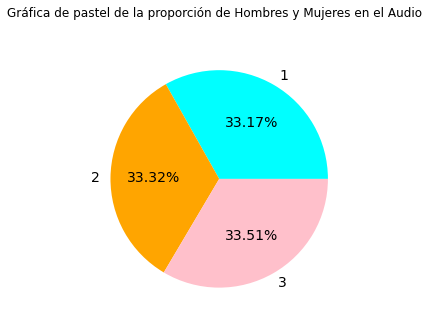

In [ ]:
df_train.groupby('Speakers')['Speakers'].agg(['count']).plot.pie(autopct="%.2f%%", colors = ['cyan', 'orange','pink'], subplots=True, figsize=(5,5), title='Gráfica de pastel de la proporción de Hombres y Mujeres en el Audio', textprops={'fontsize': 14}, legend=False)
pylab.ylabel('')
plt.show()

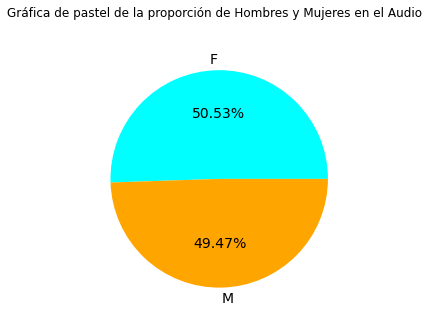

In [ ]:
df_train_1.groupby('Speakers_Sex')['Speakers_Sex'].agg(['count']).plot.pie(autopct="%.2f%%", colors = ['cyan', 'orange'], subplots=True, figsize=(5,5), title='Gráfica de pastel de la proporción de Hombres y Mujeres en el Audio', textprops={'fontsize': 14}, legend=False)
pylab.ylabel('')
plt.show()

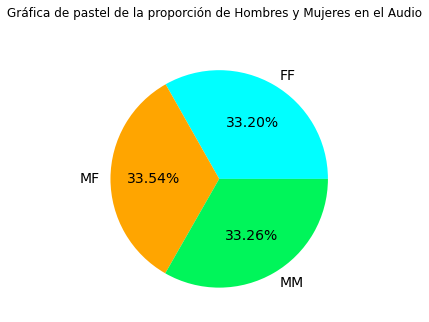

In [ ]:
df_train_2.groupby('Speakers_Sex')['Speakers_Sex'].agg(['count']).plot.pie(autopct="%.2f%%", colors = ['cyan', 'orange', '#00F55A'], subplots=True, figsize=(5,5), title='Gráfica de pastel de la proporción de Hombres y Mujeres en el Audio', textprops={'fontsize': 14}, legend=False)
pylab.ylabel('')
plt.show()

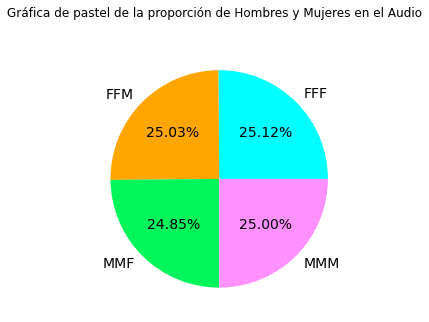

In [ ]:
df_train_3.groupby('Speakers_Sex')['Speakers_Sex'].agg(['count']).plot.pie(autopct="%.2f%%", 
                                                                          colors = ['cyan', 'orange', '#00F55A', '#FF91FF'], 
                                                                          subplots=True, figsize=(5,5), 
                                                                          title='Gráfica de pastel de la proporción de Hombres y Mujeres en el Audio', 
                                                                          textprops={'fontsize': 14}, legend=False)
pylab.ylabel('')
plt.show()

# Generación del conjunto de validación




In [14]:
# descargamos los datos de validacion
data_dev = torchaudio.datasets.LIBRISPEECH("./", url="dev-clean", download=True)

In [15]:
# cantidad de datos de validacion
len_data_dev = len(data_dev)
len_data_dev

2703

In [20]:
# Separamos los conjuntos para tener los de mujeres y hombres.
df_speakers_dev_clean = df_speakers2[df_speakers2['SUBSET'] == ' dev-clean        '].copy().reset_index()
data_F_2 = df_speakers_dev_clean[df_speakers_dev_clean["SEX"]==" F "]
data_M_2 = df_speakers_dev_clean[df_speakers_dev_clean["SEX"]==" M "]

# Corroboramos no se omita ninguno
print(f"Total: {len(data_dev)}\tFemenino: {len(data_F_2)}\tMasculino:{len(data_M_2)}")

Total: 2703	Femenino: 20	Masculino:20


In [21]:
# Obtenemos los ids de cada registro
Speakers_df_2 = Genera_DF_speakers(data_dev)

In [22]:
# Para medir el tiempo que tarda la generación
t= time()

# Ajustamos la semilla
seed(1025)

# Cantidad de elementos a generar
n = 10000

# lista donde vamos a guardar nuestros datos de entrenamiento
lista_datos_dev = []

# Generaremos nuestras n muestras de entrenamiento
for i in range(n):
    # Generamos un numero aleatorio que puede ser 1, 2 o 3
    muestra_dev = randint(1,3)
    lista_datos_dev.append(Mezcla(muestra_dev,data_dev, data_M_2, data_F_2,Speakers_df_2))

print("Tiempo de ejecución: ", time()-t)

Tiempo de ejecución:  85.05874800682068


In [23]:
df_dev = pd.DataFrame(lista_datos_dev, columns=['Waveform', 'Speakers', 'Speakers_Sex', 'F', 'M'])

# por proporcion dividimos en 3 dataframes este dataframe para generar estadísticas más
# locales de cada subconjunto
df_dev_1 = df_dev[df_dev['Speakers'] == 1]
df_dev_2 = df_dev[df_dev['Speakers'] == 2]
df_dev_3 = df_dev[df_dev['Speakers'] == 3]

## Visualización de Resultados

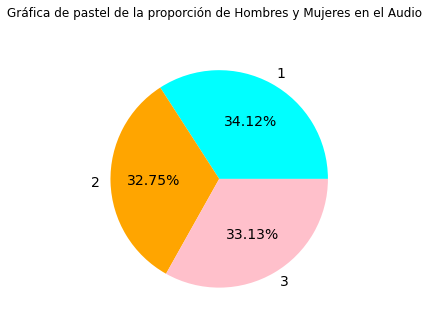

In [24]:
df_dev.groupby('Speakers')['Speakers'].agg(['count']).plot.pie(autopct="%.2f%%", colors = ['cyan', 'orange','pink'], subplots=True, figsize=(5,5), title='Gráfica de pastel de la proporción de Hombres y Mujeres en el Audio', textprops={'fontsize': 14}, legend=False)
pylab.ylabel('')
plt.show()

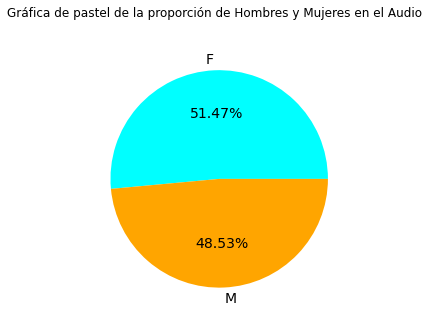

In [25]:
df_dev_1.groupby('Speakers_Sex')['Speakers_Sex'].agg(['count']).plot.pie(autopct="%.2f%%", colors = ['cyan', 'orange'], subplots=True, figsize=(5,5), title='Gráfica de pastel de la proporción de Hombres y Mujeres en el Audio', textprops={'fontsize': 14}, legend=False)
pylab.ylabel('')
plt.show()

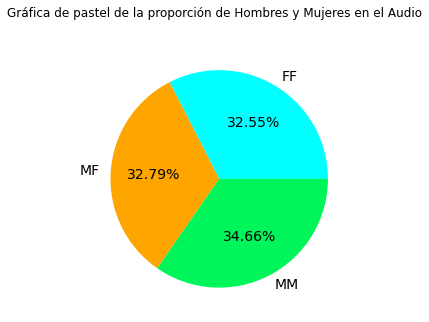

In [26]:
df_dev_2.groupby('Speakers_Sex')['Speakers_Sex'].agg(['count']).plot.pie(autopct="%.2f%%", colors = ['cyan', 'orange', '#00F55A'], subplots=True, figsize=(5,5), title='Gráfica de pastel de la proporción de Hombres y Mujeres en el Audio', textprops={'fontsize': 14}, legend=False)
pylab.ylabel('')
plt.show()

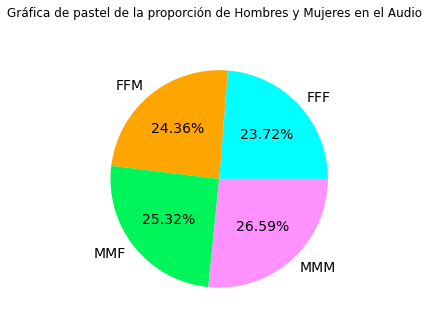

In [33]:
df_dev_3.groupby('Speakers_Sex')['Speakers_Sex'].agg(['count']).plot.pie(autopct="%.2f%%", 
                                                                          colors = ['cyan', 'orange', '#00F55A', '#FF91FF'], 
                                                                          subplots=True, figsize=(5,5), 
                                                                          title='Gráfica de pastel de la proporción de Hombres y Mujeres en el Audio', 
                                                                          textprops={'fontsize': 14}, legend=False)
pylab.ylabel('')
plt.show()

# Generación del conjunto de prueba


In [ ]:
# descargamos los datos de validacion
data_test = torchaudio.datasets.LIBRISPEECH("./", url="test-clean", download=True)

In [ ]:
# cantidad de datos de validacion
len_data_test = len(data_test)
len_data_test

2620

In [ ]:
# Separamos los conjuntos para tener los de mujeres y hombres.
df_speakers_test_clean = df_speakers2[df_speakers2['SUBSET'] == ' test-clean       '].copy().reset_index()
data_F_3 = df_speakers_test_clean[df_speakers_test_clean["SEX"]==" F "]
data_M_3 = df_speakers_test_clean[df_speakers_test_clean["SEX"]==" M "]

In [ ]:
# Obtenemos los ids de cada registro
Speakers_df_3 = Genera_DF_speakers(data_test)

In [ ]:
# Para medir el tiempo que tarda la generación
t= time()

# Ajustamos la semilla
seed(242)

# Cantidad de elementos a generar
n = 10000

# lista donde vamos a guardar nuestros datos de entrenamiento
lista_datos_test = []

# Generaremos nuestras n muestras de entrenamiento
for i in range(n):
    # Generamos un numero aleatorio que puede ser 1, 2 o 3
    muestra_test = randint(1,3)
    lista_datos_test.append(Mezcla(muestra_test,data_test,data_M_3, data_F_3,Speakers_df_3))

print("Tiempo de ejecución: ", time()-t)

Tiempo de ejecución:  128.94385409355164


In [ ]:
df_test = pd.DataFrame(lista_datos_dev, columns=['Waveform', 'Speakers', 'Speakers_Sex', 'F', 'M'])

# por proporcion dividimos en 3 dataframes este dataframe para generar estadísticas más
# locales de cada subconjunto
df_test_1 = df_test[df_test['Speakers'] == 1]
df_test_2 = df_test[df_test['Speakers'] == 2]
df_test_3 = df_test[df_test['Speakers'] == 3]

## Visualización de Resultados

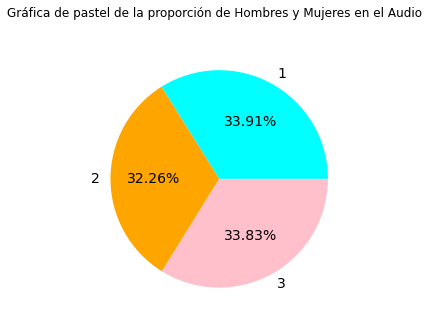

In [ ]:
df_test.groupby('Speakers')['Speakers'].agg(['count']).plot.pie(autopct="%.2f%%", colors = ['cyan', 'orange','pink'], subplots=True, figsize=(5,5), title='Gráfica de pastel de la proporción de Hombres y Mujeres en el Audio', textprops={'fontsize': 14}, legend=False)
pylab.ylabel('')
plt.show()

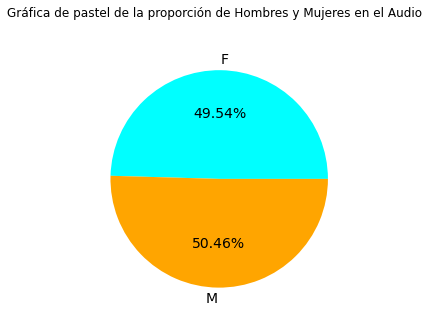

In [ ]:
df_test_1.groupby('Speakers_Sex')['Speakers_Sex'].agg(['count']).plot.pie(autopct="%.2f%%", colors = ['cyan', 'orange'], subplots=True, figsize=(5,5), title='Gráfica de pastel de la proporción de Hombres y Mujeres en el Audio', textprops={'fontsize': 14}, legend=False)
pylab.ylabel('')
plt.show()

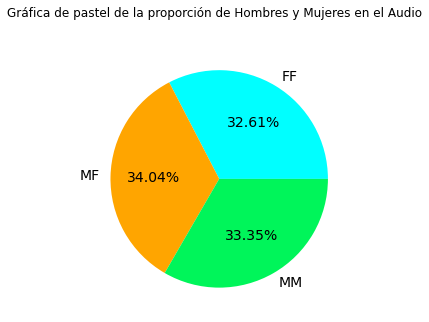

In [ ]:
df_test_2.groupby('Speakers_Sex')['Speakers_Sex'].agg(['count']).plot.pie(autopct="%.2f%%", colors = ['cyan', 'orange', '#00F55A'], subplots=True, figsize=(5,5), title='Gráfica de pastel de la proporción de Hombres y Mujeres en el Audio', textprops={'fontsize': 14}, legend=False)
pylab.ylabel('')
plt.show()

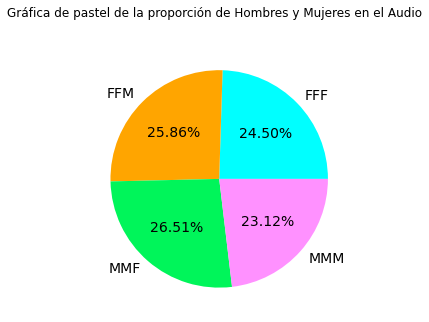

In [ ]:
df_test_3.groupby('Speakers_Sex')['Speakers_Sex'].agg(['count']).plot.pie(autopct="%.2f%%", 
                                                                          colors = ['cyan', 'orange', '#00F55A', '#FF91FF'], 
                                                                          subplots=True, figsize=(5,5), 
                                                                          title='Gráfica de pastel de la proporción de Hombres y Mujeres en el Audio', 
                                                                          textprops={'fontsize': 14}, legend=False)
pylab.ylabel('')
plt.show()

In [ ]:
print("Contamos con un total de datos:")
print(f"Entrenamiento: {len(df_train)}")
print(f"Validación: {len(df_dev)}")
print(f"Prueba: {len(df_test)}")

Contamos con un total de datos:
Entrenamiento: 100000
Validación: 10000
Prueba: 10000


# Almacenamos los metadatos

In [30]:
from google.colab import drive
 
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [28]:
#df_train.to_csv("Entrenamiento.csv",index=False)
df_dev.to_csv("drive/My Drive/Intro_Ap_Prof/Proyecto/Validacion.csv",index=False)
#df_test.to_csv("Prueba.csv",index=False)

# Almacenamos los audios

In [ ]:
almacena_audios("./Entrenamiento",df_train,"Train")

Audios Almacenados!!!


In [ ]:
almacena_audios("./Prueba",df_test,"Test")

Audios Almacenados!!!


In [31]:
almacena_audios("./Validacion",df_dev,"Validation")

Audios Almacenados!!!
